### Transfer learning

#### Main intuition: 
- Train a model using a specific set of training data
- Save the model
- Use the pre-trained model for a new problem/dataset
- Re-train using the new dataset

#### When do we use it:
If we have a small dataset, not big enough for proper training. The use of a pre-trained model on much larger dataset provides a better initialization

#### Examples:
The most common example is: ImageNet network + transfer learning to specific dataset


In [14]:
from __future__ import print_function

import datetime
from tensorflow.keras.datasets import mnist

##from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import utils as utils
from tensorflow.keras import backend as K


In [2]:
now = datetime.datetime.now

batch_size = 128
num_classes = 5
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
filters = 32
# size of pooling area for max pooling
pool_size = 2
# convolution kernel size
kernel_size = 3


In [3]:
K.backend()

'tensorflow'

In [4]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)


In [15]:
def train_model(model, train, test, num_classes):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = utils.to_categorical(train[1], num_classes)
    y_test = utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    t = now()
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    print('Training time: %s' % (now() - t))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])


In [6]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


11490434/11490434 [==============================] - 1s 0us/step


In [7]:
# create two datasets one with digits below 5 and one with 5 and above
x_train_lt5 = x_train[y_train < 5]
y_train_lt5 = y_train[y_train < 5]
x_test_lt5 = x_test[y_test < 5]
y_test_lt5 = y_test[y_test < 5]

x_train_gte5 = x_train[y_train >= 5]
y_train_gte5 = y_train[y_train >= 5] - 5
x_test_gte5 = x_test[y_test >= 5]
y_test_gte5 = y_test[y_test >= 5] - 5



In [8]:
# define two groups of layers: feature (convolutions) and classification (dense)
feature_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax')
]


In [9]:
# create complete model
model = Sequential(feature_layers + classification_layers)


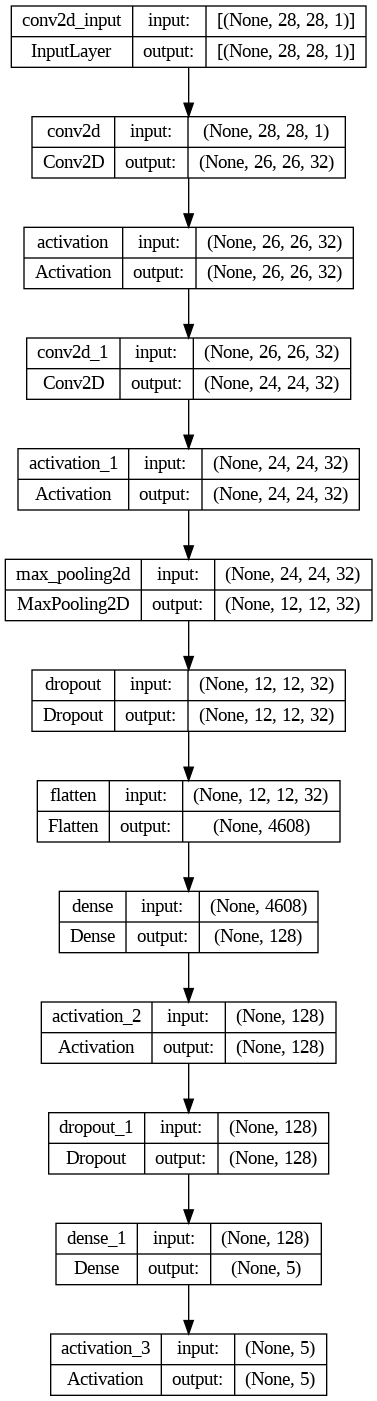

In [10]:
from keras.utils import plot_model

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# train model for 5-digit classification [0..4]
train_model(model,
            (x_train_lt5, y_train_lt5),
            (x_test_lt5, y_test_lt5), num_classes)


x_train shape: (30596, 28, 28, 1)
30596 train samples
5139 test samples
Epoch 1/5
213/240 [=========================>....] - ETA: 7s - loss: 1.6067 - accuracy: 0.2450

In [ ]:
# freeze feature  layers and rebuild model
for l in feature_layers:
    l.trainable = False


In [ ]:

# transfer: train dense layers for new classification task [5..9]
train_model(model,
            (x_train_gte5, y_train_gte5),
            (x_test_gte5, y_test_gte5), num_classes)